In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from shutil import rmtree
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime

In [2]:
### path of the log
cpu_log = Path('/home/lizz_lab/cse12232433/project/colmena/multisite_/molecular-design/runs/20231007_104929/gpu005cpu_usage_20231007_104933.log')
gpu_log = Path('/home/lizz_lab/cse12232433/project/colmena/multisite_/molecular-design/runs/20231007_104929/gpu005gpu_usage_20231007_104933.log')
mem_log = Path('/home/lizz_lab/cse12232433/project/colmena/multisite_/molecular-design/runs/20231007_104929/gpu005mem_usage_20231007_104933.log')


In [3]:
#### draft code
## process gpu util
# df = pd.read_csv(gpu_log)

# # 将 Timestamp 列转换为日期时间类型
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# # timestamp = df['Timestamp']

# # 绘制 GPU 利用率折线图
# plt.figure(figsize=(10, 6))
# # timestamp not accurate， some data share the same timestamp
# # gpu_utilization = df.groupby('Timestamp')['GPU Utilization (%)']
# # timestamp = gpu_utilization.groups.keys()
# # gpu_utilization_mean = gpu_utilization.mean()
# # rows = gpu_utilization.head(60*10*4)
# gpu_utilization_group = df.groupby('GPUs')['GPU Utilization (%)']
# gpu = [ gpu_utilization_group.get_group(i) for i in range(0, len(gpu_utilization_group.groups.keys()))]


# rows_plot = [rows[i] for i in range(0, len(rows), 4)]
# plt.plot(gpu[0], label='GPU 0', color='red', linestyle='--')
# # plt.plot(gpu_utilization_mean, label='GPU Mean', color='blue', linestyle='--')
# # gpu_utilization.plot()
# plt.xlabel('Timestamp')
# plt.ylabel('GPU Utilization (%)')
# plt.title('GPU Utilization Over Time')
# plt.grid(True)
# # print(len(df.groupby('Timestamp')['GPU Utilization (%)']))
# # print(gpu_utilization_group.groups.keys())

#### functions
def get_gpu_data(gpu_log:str) -> pd.DataFrame:
    df = pd.read_csv(gpu_log)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    gpu_utilization_group = df.groupby('GPUs')['GPU Utilization (%)']
    gpu = [ gpu_utilization_group.get_group(i) for i in range(0, len(gpu_utilization_group.groups.keys()))]
    return gpu

def plot_gpu_util(gpu:list[pd.DataFrame]) -> None:
    gpu = get_gpu_data(gpu_log)
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'orange']
    for i in range(len(gpu)):
        plt.plot([i for i in range(len(gpu[i]))],gpu[i], label=f'GPU {i}', color=colors[i], linestyle='--')
        plt.legend()
    # plt.plot(gpu[0], label='GPU 0', color='red', linestyle='--')
    plt.xlabel('Timestamp')
    plt.ylabel('GPU Utilization (%)')
    plt.title('GPU Utilization Over Time')
    plt.grid(True)

In [5]:
# TODO add time stamp to the plot, now gpu has no timestamp
# df = pd.read_csv(gpu_log)
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# gpu_utilization_group = df.groupby('GPUs')['GPU Utilization (%)']
# time_stamp = df.groupby('GPUs')['Timestamp']
# a=time_stamp.groups.values()
# print(a)
# print(df['Timestamp'].iloc[0])
# list = df.values.tolist()

dict_values([Int64Index([    0,     4,     8,    12,    16,    20,    24,    28,    32,
               36,
            ...
            13316, 13320, 13324, 13328, 13332, 13336, 13340, 13344, 13348,
            13352],
           dtype='int64', length=3339), Int64Index([    1,     5,     9,    13,    17,    21,    25,    29,    33,
               37,
            ...
            13317, 13321, 13325, 13329, 13333, 13337, 13341, 13345, 13349,
            13353],
           dtype='int64', length=3339), Int64Index([    2,     6,    10,    14,    18,    22,    26,    30,    34,
               38,
            ...
            13318, 13322, 13326, 13330, 13334, 13338, 13342, 13346, 13350,
            13354],
           dtype='int64', length=3339), Int64Index([    3,     7,    11,    15,    19,    23,    27,    31,    35,
               39,
            ...
            13319, 13323, 13327, 13331, 13335, 13339, 13343, 13347, 13351,
            13355],
           dtype='int64', length=3339)])
2023-0

In [4]:
## cpu util functions
header_pattern = r'\((\d+) CPU\)'
data_pattern = r'^\d{2}:\d{2}:\d{2} [AP]M\s+(\w+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)'
pattern = [header_pattern,data_pattern]
def get_cpu_util(path:Path,pattern:list[str]) -> list:
    
    with open (path, 'r') as file:
        ## only get one header
        time = []
        is_header = True
        for line in file:
            line = line.strip()
            
            if is_header:
                match = re.search(pattern[0], line)
                if match:
                    num_cpu = int(match.group(0)[1:3])
                    print("number of cpus:")
                    print(num_cpu)
                    cpu_utilization = [[] for i in range (0,num_cpu+1)]
                    is_header = False
            
            match = re.match(pattern[1],line)
            if match:
                cpu_stats = [match.group(i) for i in range(1,12)]
                # get time stamp
                time_stamp = match.group(0)[0:8]
                am_pm = match.group(0)[9:11]
                # convert it to 24-hour
                time_obj = datetime.strptime(time_stamp + am_pm, "%I:%M:%S%p")
                time_24h_str = time_obj.strftime("%H:%M:%S")
                # cpu_utilization[i].append([time_24h_str] + cpu_stats)
                if (cpu_stats[0] == 'all'):
                    cpu_utilization[num_cpu].append([round(float(i)) for i in cpu_stats[1:]])
                else:
                    cpu_utilization[int(cpu_stats[0])].append([round(float(i)) for i in cpu_stats[1:]])
                if(cpu_stats[0]=='0'):
                    time.append(time_24h_str)
                
    return time,cpu_utilization

def plt_cpu_util(time_stamp:list,cpu_util:list,title:str,cpu_num:int=-1):
    # plt.figure(figsize=(100,100))
    plt.plot(time_stamp,cpu_util)
    
    # 添加标题和坐标轴标签
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Utilization (%)')
    # 显示图形
    plt.grid(True)
    plt.show()
    

In [5]:

## plt mem util
def get_mem_data(mem_log:str)->pd.DataFrame:
    df = pd.read_csv(mem_log, sep=r'\s+')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    list = df.values.tolist()
    return list

def plt_mem_util(mem_data:list,title:str):
    plt.figure()
    plt.plot([i[0] for i in mem_data],[i[3] for i in mem_data])
    # 设置 y 轴刻度个数
    num_ticks = 8
    y_ticks = np.linspace(0, 128, num_ticks, dtype=int)
    # 设置 x 轴刻度标签
    y_tick_labels = [f'{val:.1f}' for val in y_ticks]
    plt.yticks(y_ticks, y_tick_labels, rotation=45)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mem Usage (Gb)')
    plt.grid(True)
    plt.show()

number of cpus:
56


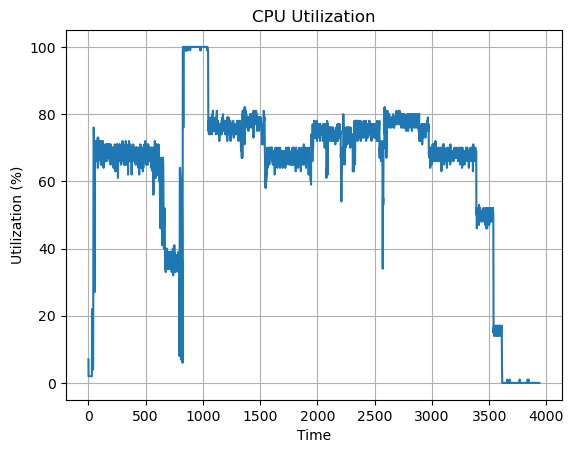

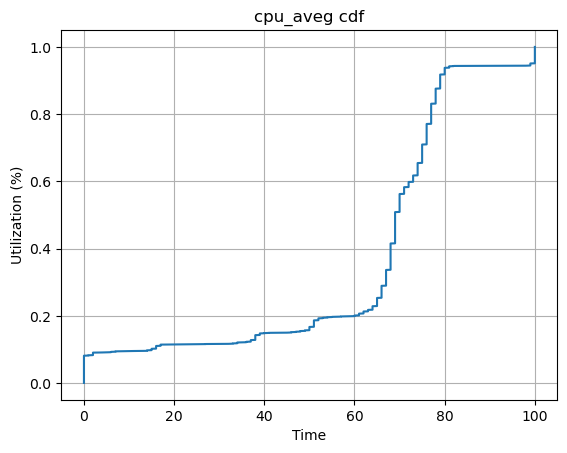

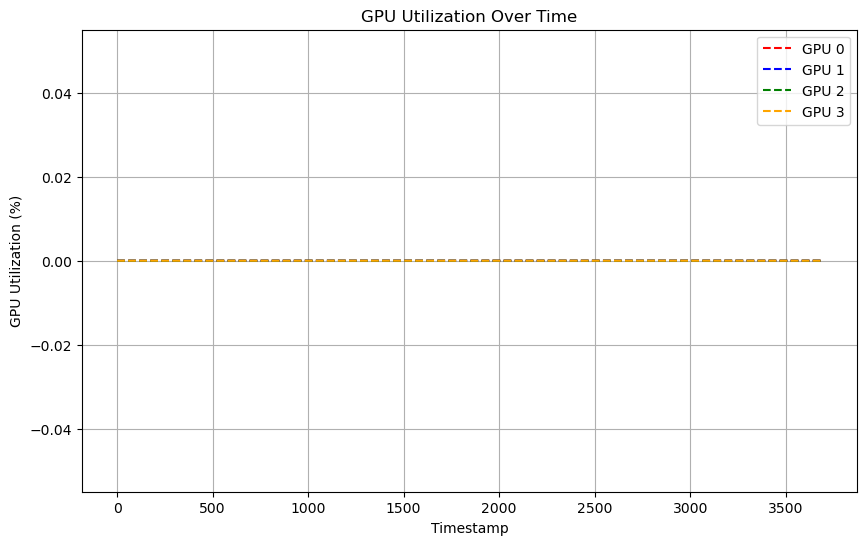

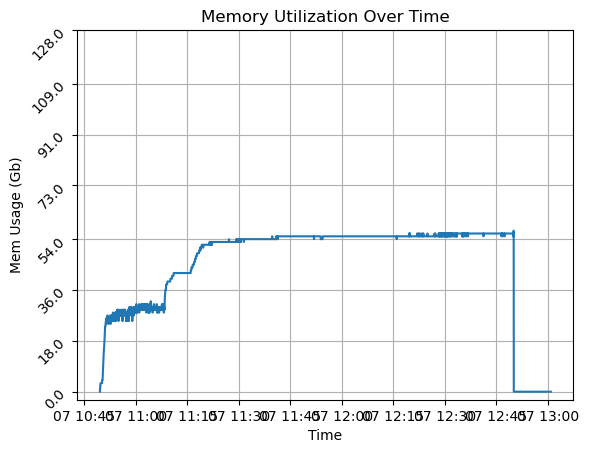

In [6]:
## plot cpu
time_stamp,cpu_utilization = get_cpu_util(cpu_log,pattern)
# print(len(cpu_utilization))
# print(type(pattern))
# print(type(pattern[0]))
cpu_util = [round(100 - cpu_utilization[-1][i][-1]) for i in range(0,len(cpu_utilization[0]))]
## just use 10 mins data
# cpu_util = cpu_util[0:10*60]
sorted = np.sort(cpu_util)
cdf = np.arange(1,len(sorted)+1)/len(sorted)
plt_cpu_util([i for i in range(0,len(cpu_util))],cpu_util,'CPU Utilization')
plt_cpu_util(sorted,cdf,"cpu_aveg cdf")

## plot gpu
gpu_data = get_gpu_data(gpu_log)
plot_gpu_util(gpu_data)

## plot mem
mem_data = get_mem_data(mem_log)
plt_mem_util(mem_data,'Memory Utilization Over Time')

number of cpus:
56


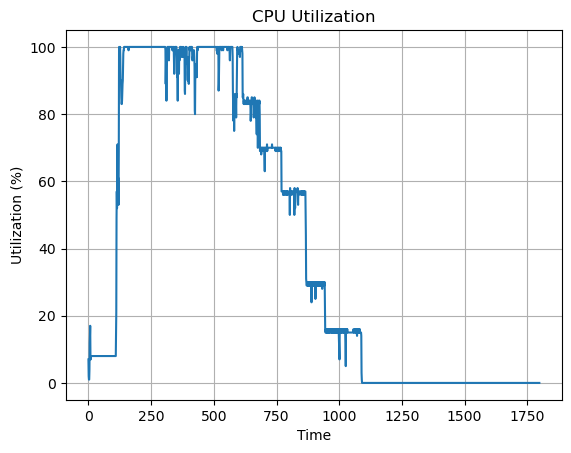

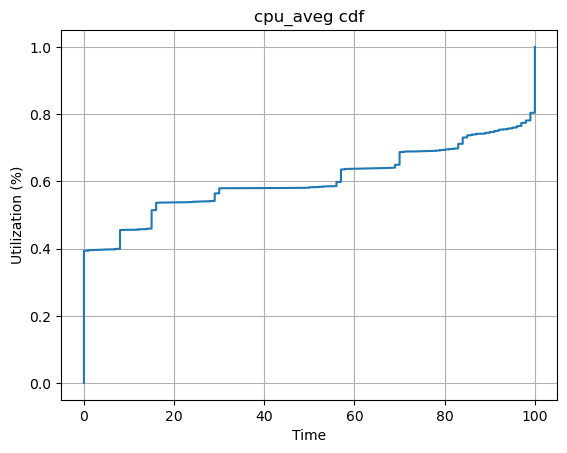

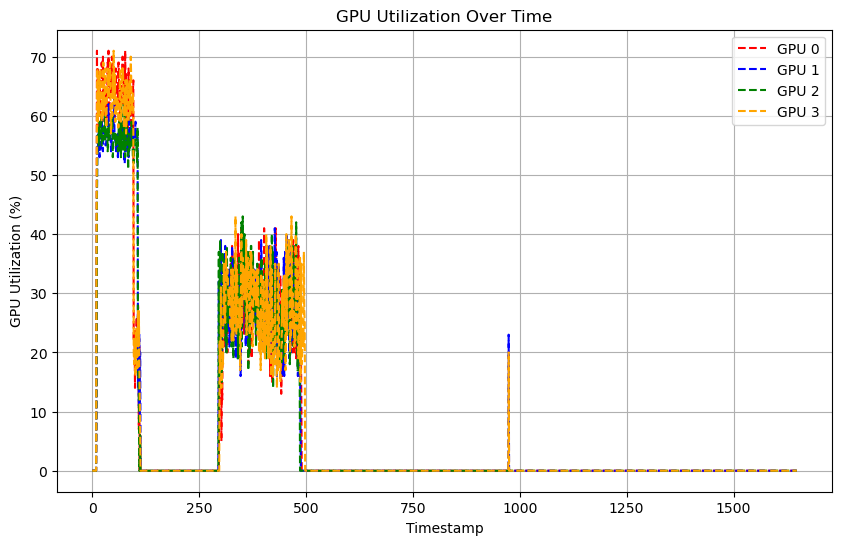

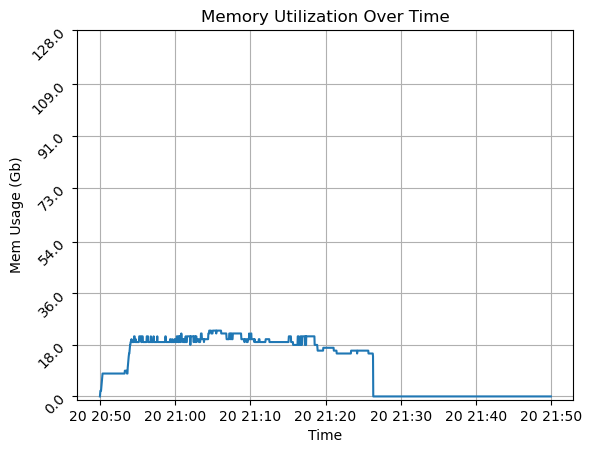

In [32]:
## plot cpu
time_stamp,cpu_utilization = get_cpu_util(cpu_log,pattern)
# print(len(cpu_utilization))
# print(type(pattern))
# print(type(pattern[0]))
cpu_util = [round(100 - cpu_utilization[-1][i][-1]) for i in range(0,len(cpu_utilization[0]))]
## just use 10 mins data
# cpu_util = cpu_util[0:10*60]
sorted = np.sort(cpu_util)
cdf = np.arange(1,len(sorted)+1)/len(sorted)
plt_cpu_util([i for i in range(0,len(cpu_util))],cpu_util,'CPU Utilization')
plt_cpu_util(sorted,cdf,"cpu_aveg cdf")

## plot gpu
gpu_data = get_gpu_data(gpu_log)
plot_gpu_util(gpu_data)

## plot mem
mem_data = get_mem_data(mem_log)
plt_mem_util(mem_data,'Memory Utilization Over Time')

number of cpus:
56


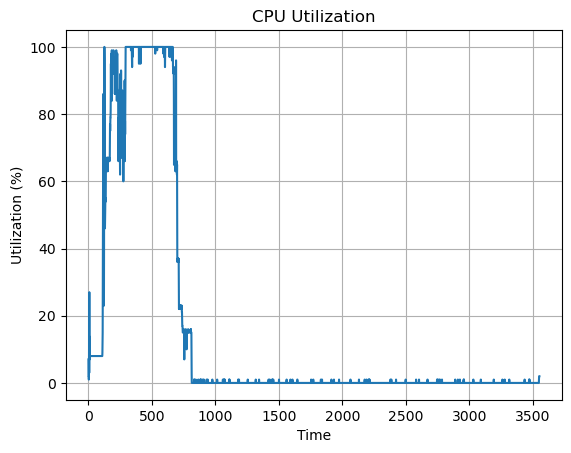

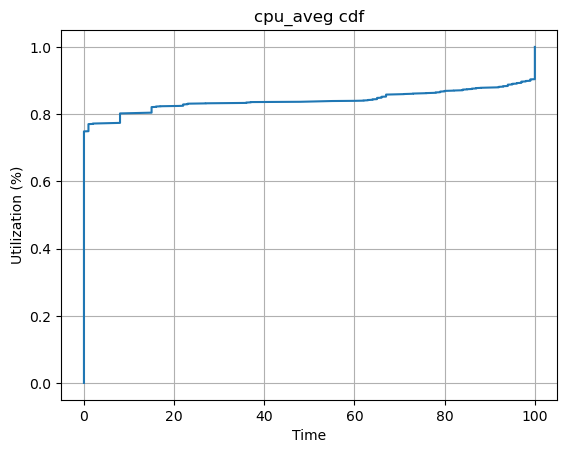

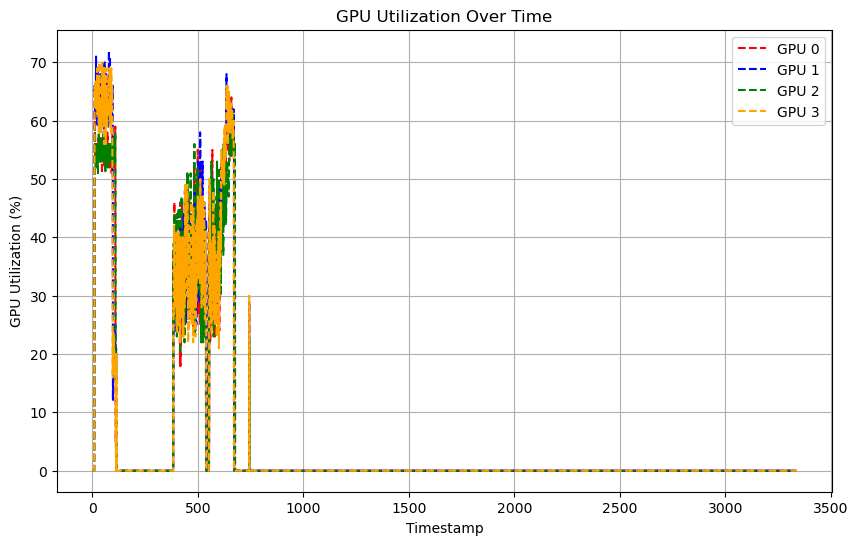

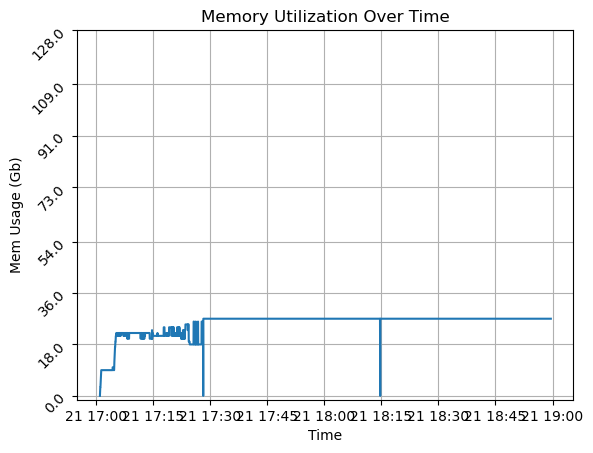

In [7]:
## plot cpu
time_stamp,cpu_utilization = get_cpu_util(cpu_log,pattern)
# print(len(cpu_utilization))
# print(type(pattern))
# print(type(pattern[0]))
cpu_util = [round(100 - cpu_utilization[-1][i][-1]) for i in range(0,len(cpu_utilization[0]))]
## just use 10 mins data
# cpu_util = cpu_util[0:10*60]
sorted = np.sort(cpu_util)
cdf = np.arange(1,len(sorted)+1)/len(sorted)
plt_cpu_util([i for i in range(0,len(cpu_util))],cpu_util,'CPU Utilization')
plt_cpu_util(sorted,cdf,"cpu_aveg cdf")

## plot gpu
gpu_data = get_gpu_data(gpu_log)
plot_gpu_util(gpu_data)

## plot mem
mem_data = get_mem_data(mem_log)
plt_mem_util(mem_data,'Memory Utilization Over Time')

number of cpus:
56


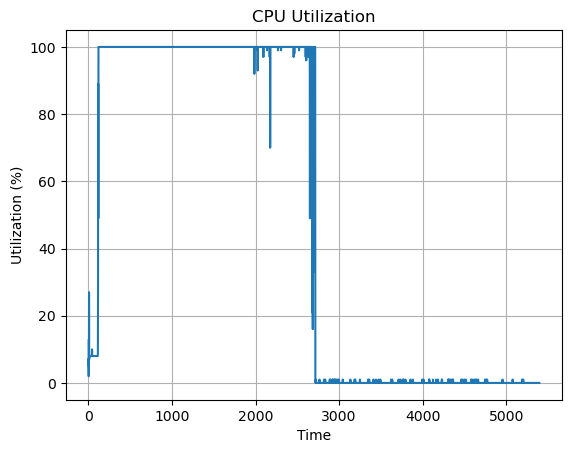

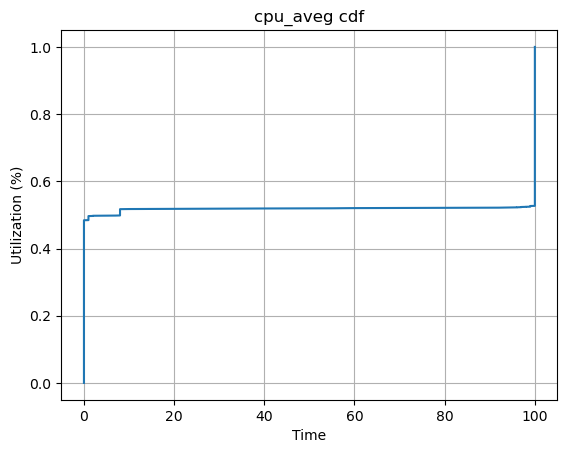

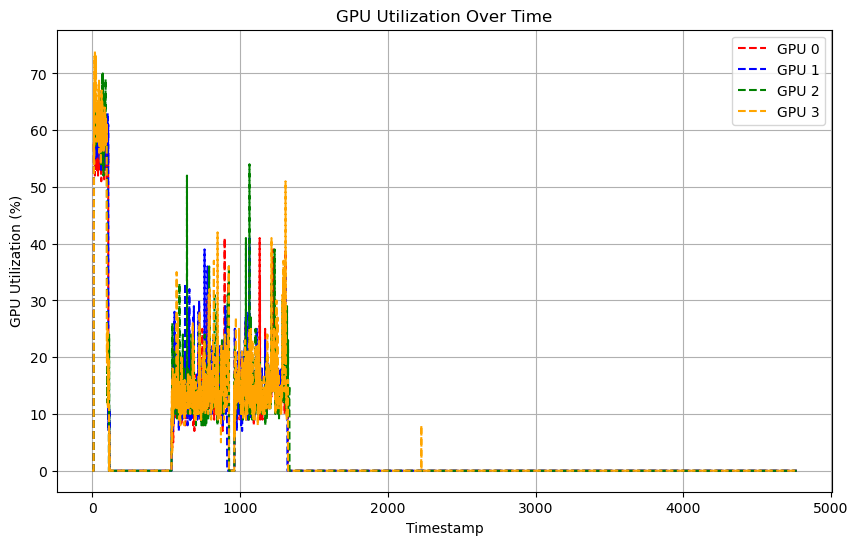

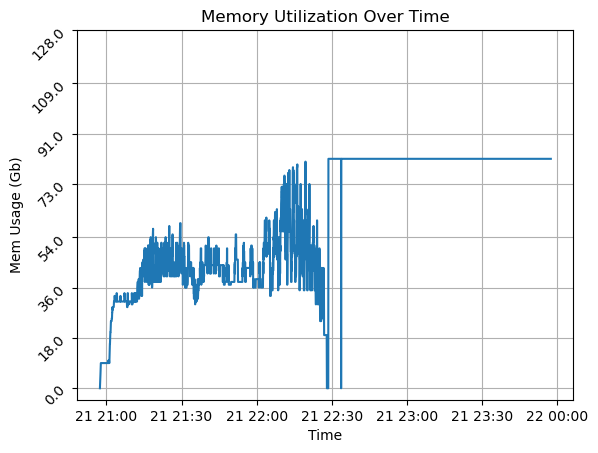

In [13]:
## plot cpu
time_stamp,cpu_utilization = get_cpu_util(cpu_log,pattern)
# print(len(cpu_utilization))
# print(type(pattern))
# print(type(pattern[0]))
cpu_util = [round(100 - cpu_utilization[-1][i][-1]) for i in range(0,len(cpu_utilization[0]))]
## just use 10 mins data
# cpu_util = cpu_util[0:10*60]
sorted = np.sort(cpu_util)
cdf = np.arange(1,len(sorted)+1)/len(sorted)
plt_cpu_util([i for i in range(0,len(cpu_util))],cpu_util,'CPU Utilization')
plt_cpu_util(sorted,cdf,"cpu_aveg cdf")

## plot gpu
gpu_data = get_gpu_data(gpu_log)
plot_gpu_util(gpu_data)

## plot mem
mem_data = get_mem_data(mem_log)
plt_mem_util(mem_data,'Memory Utilization Over Time')